# 07. bonniema/salary-predictor

## Model 3: Use Pre-trained GloVe Model

## Import libraries and the final salary dataset

In [1]:
import time
from time import time
from pprint import pprint
import pickle
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import logging

# NLP
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk import word_tokenize, FreqDist
from nltk.collocations import *
import string, re
from gensim.models import Word2Vec
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer

# Model Data Preparation
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer

# Machine Learning
from sklearn.metrics import accuracy_score, f1_score, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression, SGDClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix

# Deep learning
import tensorflow as tf
# from keras.preprocessing.sequence import pad_sequences
from keras.utils import pad_sequences
from keras.layers import Input, Dense, LSTM, Embedding
from keras.layers import Dropout, Activation, Bidirectional, GlobalMaxPool1D
from keras.layers.convolutional import Conv1D, Conv2D
from keras.layers.convolutional import MaxPooling1D, MaxPooling2D
from keras.models import Sequential
from keras import initializers, regularizers, constraints, optimizers, layers
from keras.preprocessing import text, sequence
from keras.layers import Flatten
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from keras import regularizers
from keras.wrappers.scikit_learn import KerasClassifier #to use Keras in sklearn

# Deep Learning - Mixed inputs
# from keras.layers.normalization import BatchNormalization
from tensorflow.keras.layers import BatchNormalization
from keras.layers.core import Activation
from keras.layers.core import Dropout
from keras.layers.core import Dense
from keras.layers import Flatten
from keras.layers import Input
from keras.models import Model
from keras.layers import concatenate
from keras.optimizers import Adam, RMSprop

%matplotlib inline
np.random.seed(0)

[nltk_data] Downloading package stopwords to C:\Users\Doğan Yiğit
[nltk_data]     Yenigün\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
salary_df = pd.read_csv('salary_final_done.csv')

In [4]:
print(salary_df.shape)
salary_df.drop('Unnamed: 0.2', axis=1, inplace=True)
salary_df.drop('Unnamed: 0.1', axis=1, inplace=True)
salary_df.drop('Unnamed: 0', axis=1, inplace=True)
salary_df.head()

(963, 27)


,Title,Company,Link,Review,Salary,Description,Location2,Rate_by,low,high,...,Rank,City,Cost of Living Index,Rent Index,Cost of Living Plus Rent Index,Groceries Index,Restaurant Price Index,Local Purchasing Power Index,combined_text,Salary_Bins
0,"2021048 Data Scientist $215,000.00",B4CORP,https://www.indeed.com/pagead/clk?mo=r&ad=-6NY...,None,"Up to $215,000 a year",Position Requires a Top Secret (TS/SCI) Cleara...,"Arlington, VA",Yearly,"Up to $215,000 a year",NaN,...,36.0,"Arlington, VA",80.159143,58.838571,69.961143,76.886286,78.608571,115.594571,"2021048 Data Scientist $215,000.00 Position Re...",5
1,Data Science/Data Analyst,CRAiC LLC,https://www.indeed.com/company/CRAiC-LLC/jobs/...,None,"$60,000 a year",Cost Readiness Analytics (CRAiC LLC) is lookin...,"Arlington, VA",Yearly,"$60,000 a year",NaN,...,36.0,"Arlington, VA",80.159143,58.838571,69.961143,76.886286,78.608571,115.594571,Data Science/Data Analyst Cost Readiness Analy...,1
2,Data Science Intern,MilliporeSigma,https://www.indeed.com/company/Serono/jobs/Dat...,3.9,$20 - $25 an hour,Job Title: Data Science Intern\rA career with ...,"Arlington, VA",Hourly,$20,$25 an hour,...,36.0,"Arlington, VA",80.159143,58.838571,69.961143,76.886286,78.608571,115.594571,Data Science Intern Job Title: Data Science In...,0
3,Jr. Data Scientist,Numero Data LLC,https://www.indeed.com/company/Numero-Data-LLC...,None,"$70,000 - $85,000 a year",Ideal candidate should have a degree in a quan...,"Arlington, VA",Yearly,"$70,000","$85,000 a year",...,36.0,"Arlington, VA",80.159143,58.838571,69.961143,76.886286,78.608571,115.594571,Jr. Data Scientist Ideal candidate should have...,2
4,Business Data Quality Engineer,HRU Technical Resources,https://www.indeed.com/pagead/clk?mo=r&ad=-6NY...,None,$45 - $55 an hour,Please note that this is not a corp to corp or...,"Arlington, VA",Hourly,$45,$55 an hour,...,36.0,"Arlington, VA",80.159143,58.838571,69.961143,76.886286,78.608571,115.594571,Business Data Quality Engineer Please note tha...,3


In [5]:
salary_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 963 entries, 0 to 962
Data columns (total 24 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Title                           963 non-null    object 
 1   Company                         963 non-null    object 
 2   Link                            963 non-null    object 
 3   Review                          963 non-null    object 
 4   Salary                          963 non-null    object 
 5   Description                     963 non-null    object 
 6   Location2                       958 non-null    object 
 7   Rate_by                         963 non-null    object 
 8   low                             963 non-null    object 
 9   high                            762 non-null    object 
 10  min                             963 non-null    float64
 11  max                             963 non-null    float64
 12  adjusted_salary                 963 

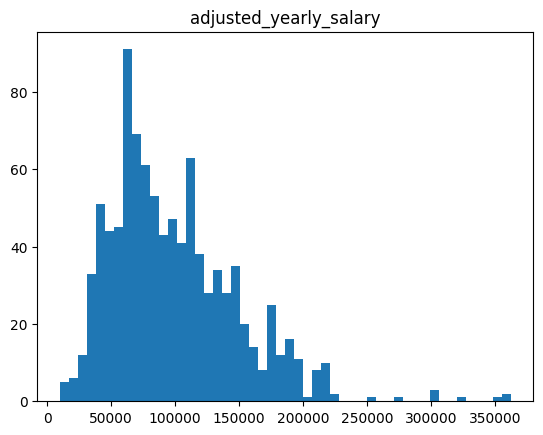

In [6]:
salary_df.hist('adjusted_yearly_salary', bins=50)
plt.grid(axis='both')
plt.show()

In [7]:
salary_df['adjusted_yearly_salary'].max() - salary_df['adjusted_yearly_salary'].min()

352500.0

In [8]:
salary_df['adjusted_yearly_salary'].quantile(list(np.linspace(0,1,7)))

0.000000     10000.000000
0.166667     54026.666667
0.333333     70000.000000
0.500000     90000.000000
0.666667    114400.000000
0.833333    145600.000000
1.000000    362500.000000
Name: adjusted_yearly_salary, dtype: float64

In [10]:
salary_df['Salary_Bins']

0      5
1      1
2      0
3      2
4      3
      ..
958    3
959    3
960    3
961    2
962    2
Name: Salary_Bins, Length: 963, dtype: int64

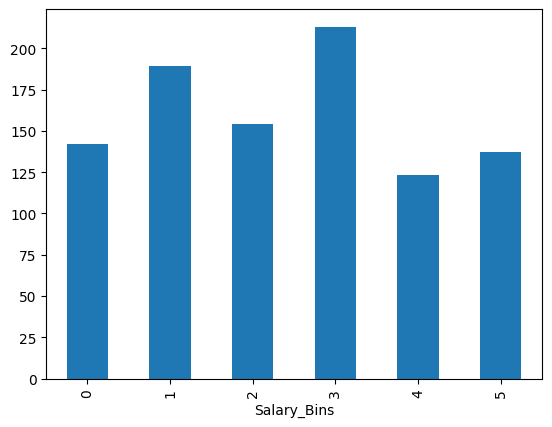

In [11]:
salary_df.groupby('Salary_Bins')['Location2'].count().plot.bar()
plt.show()

In [12]:
# Categorical target
target_class = salary_df['Salary_Bins'].astype('category')

In [13]:
target_class

0      5
1      1
2      0
3      2
4      3
      ..
958    3
959    3
960    3
961    2
962    2
Name: Salary_Bins, Length: 963, dtype: category
Categories (6, int64): [0, 1, 2, 3, 4, 5]

In [14]:
def clean_word(job_descriptions):
    jd_data=[]
    pattern = "([a-zA-Z]+(?:'[a-z]+)?)"
    stopwords_list = stopwords.words('english')
    stopwords_list += list(string.punctuation)
    stopwords_list += ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
    stopwords_list += ['www','http','com','llc','covid','non','pm','am','eg','e','g','ie','i']
    
    for jd in job_descriptions:
        jd_tokens_raw = nltk.regexp_tokenize(jd, pattern)
        jd_tokens=[word.lower() for word in jd_tokens_raw]
        jd_words_stopped = [word for word in jd_tokens if word not in stopwords_list]
        jd_data.append(jd_words_stopped)

    return pd.Series(jd_data) # Turn list of lists to series of lists to use in Word2Vec

In [15]:
data = clean_word(salary_df['combined_text'])

In [16]:
data

0      [data, scientist, position, requires, top, sec...
1      [data, science, data, analyst, cost, readiness...
2      [data, science, intern, job, title, data, scie...
3      [jr, data, scientist, ideal, candidate, degree...
4      [business, data, quality, engineer, please, no...
                             ...                        
958    [data, engineering, ii, data, engineering, ii,...
959    [ir, day, shift, tier, ir, day, shift, salary,...
960    [security, engineer, security, engineer, salar...
961    [fdp, analyst, position, title, fdp, analyst, ...
962    [junior, ms, access, vba, developer, want, acc...
Length: 963, dtype: object

## Model 3: Use Pre-trained GloVe Model

_GloVe (Global Vectors for Word Representation) is an unsupervised algorithm for obtaining vector representations for words. Training is performed on aggregated global word-word co-occurrence statistics from a corpus, and the resulting representations showcase interesting linear substructures of the word vector space._

**The pre-trained word vector being used:** glove.6B.50d.txt

Wikipedia 2014, Gigaword 5 (6B tokens, 400K vocab, uncased, 50d, 100d, 200d & 300d vectors, 822 MB size)

Visit this web page to download the necessary word vector: https://nlp.stanford.edu/projects/glove/

In [34]:
total_vocabulary = set(word for jd in data for word in jd)
max_length=len(total_vocabulary)
print('There are {} unique tokens in the dataset.'.format(len(total_vocabulary)))

There are 13262 unique tokens in the dataset.


In [21]:
# Get the appropriate vectors out of the GloVe file
glove = {}
with open('glove.6B.50d.txt', 'rb') as f:
    for line in f:
        parts = line.split()
        word = parts[0].decode('utf-8')
        if word in total_vocabulary:   
            vector = np.array(parts[1:], dtype=np.float32)
            glove[word] = vector

In [26]:
# Each word has a 50-dimension vector space
glove['said']

array([ 0.38973  , -0.2121   ,  0.51837  ,  0.80136  ,  1.0336   ,
       -0.27784  , -0.84525  , -0.25333  ,  0.12586  , -0.90342  ,
        0.24975  ,  0.22022  , -1.2053   , -0.53771  ,  1.0446   ,
        0.62778  ,  0.39704  , -0.15812  ,  0.38102  , -0.54674  ,
       -0.44009  ,  1.0976   ,  0.013069 , -0.89971  ,  0.41226  ,
       -2.2309   ,  0.28997  ,  0.32175  , -0.72738  , -0.092244 ,
        3.028    , -0.062599 ,  0.038329 ,  0.0072918, -0.35388  ,
       -0.92256  ,  0.097932 ,  0.10068  ,  1.2116   ,  0.88233  ,
       -0.46297  ,  1.3186   ,  0.32705  , -0.73446  ,  0.89301  ,
       -0.45324  , -1.2698   ,  0.86119  ,  0.1415   ,  1.2018   ],
      dtype=float32)

In [27]:
len(next(iter(glove)))

4

In [29]:
class W2vVectorizer(object):
    def __init__(self, w2v):
        # Takes in a dictionary of words and vectors as input
        self.w2v = w2v
        if len(w2v) == 0:
            self.dimensions = 0
        else:
            self.dimensions = len(w2v[next(iter(glove))])
            
    # Note: Even though it doesn't do anything, it's required that this object implement a fit method or else
    # it can't be used in a scikit-learn pipeline  
    def fit(self, X, y):
        return self
    
    def transform(self, X):
        return np.array([
            np.mean([self.w2v[w] for w in words if w in self.w2v]
                   or [np.zeros(self.dimensions)], axis=0) for words in X])

# To be able to use in a pipeline, we need to fit and transform

### Random Forest Classifier with Grid Search

In [31]:
# TRAIN TEST SPLIT
X_train, X_test, y_train, y_test = train_test_split(data, target_class, test_size=0.1, random_state=4)

In [32]:
pipeline =  Pipeline([('Word2Vec Vectorizer', W2vVectorizer(glove)),
                      ('rf', RandomForestClassifier(n_jobs=3))])

parameters = {
    'rf__n_estimators': (30,50,80),
    'rf__criterion': ("gini","entropy"),
    'rf__min_samples_split': (4,6,8),
    'rf__max_features': ("auto","sqrt","log2")
}
                
if __name__ == "__main__":
    # Multiprocessing requires the fork to happen in a __main__ protected block
    # Find the best parameters for both the feature extraction and the classifier
    grid_search = GridSearchCV(pipeline, parameters, n_jobs=-1, verbose=1)

    print("Performing grid search...")
    print("pipeline:", [name for name, _ in pipeline.steps])
    print("parameters:")
    pprint(parameters)
    t0 = time()
    grid_search.fit(X_train, y_train)
    print("done in %0.3fs" % (time() - t0))
    print()

    print("Best score: %0.3f" % grid_search.best_score_)
    print("Best parameters set:")
    best_parameters = grid_search.best_estimator_.get_params()
    for param_name in sorted(parameters.keys()):
        print("\t%s: %r" % (param_name, best_parameters[param_name]))

Performing grid search...
pipeline: ['Word2Vec Vectorizer', 'rf']
parameters:
{'rf__criterion': ('gini', 'entropy'),
 'rf__max_features': ('auto', 'sqrt', 'log2'),
 'rf__min_samples_split': (4, 6, 8),
 'rf__n_estimators': (30, 50, 80)}
Fitting 5 folds for each of 54 candidates, totalling 270 fits
done in 150.802s

Best score: 0.472
Best parameters set:
	rf__criterion: 'entropy'
	rf__max_features: 'sqrt'
	rf__min_samples_split: 4
	rf__n_estimators: 80


In [45]:
rf = Pipeline([('Word2Vec Vectorizer', W2vVectorizer(glove)),
               ('rf', RandomForestClassifier(n_jobs=3, criterion='entropy',  max_features='log2', min_samples_split=4, 
                                             n_estimators=100))])

In [46]:
rf.fit(X_train, y_train)

Pipeline(steps=[('Word2Vec Vectorizer',
                 <__main__.W2vVectorizer object at 0x0000022125C16890>),
                ('rf',
                 RandomForestClassifier(criterion='entropy',
                                        max_features='log2',
                                        min_samples_split=4, n_jobs=3))])

In [47]:
rf.score(X_test, y_test)

0.5257731958762887

### SGD Classifier with Pipeline

In [62]:
SGD =  Pipeline([('Word2Vec Vectorizer', W2vVectorizer(glove)),
                 ('SGD', SGDClassifier(alpha=0.01, max_iter=500, n_jobs=3))])

In [68]:
SGD.fit(X_train, y_train)

Pipeline(steps=[('Word2Vec Vectorizer',
                 <__main__.W2vVectorizer object at 0x0000022128090BE0>),
                ('SGD', SGDClassifier(alpha=0.01, max_iter=500, n_jobs=3))])

In [69]:
SGD.score(X_test, y_test)

0.32989690721649484

Well, SGD performs worse than RandomForest in this case.